# IMDA Dataset processing

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [2]:
rule_based_result_df = pd.read_excel("../data/processed/IMDA_V2_Sentiment_label_0812.xlsx")
gemini_result_df= pd.read_excel("../data/processed/IMDA_filter_V3b_Gemini_0823-80K.xlsx")
gemini_result_df = gemini_result_df.drop(columns=['session_id', 'speaker_id', 'speaker_type', 'dialog_type','text', 'cleaned_text_for_sentiment', 
                                                  'word_count', 'duration','qualified_for_sentiment'])
rule_based_result_df = rule_based_result_df.drop(columns=['Unnamed: 0','V-1', 'T-1','S-1','Manual', 'Unnamed: 35'])

# Round 'x_min' and 'x_max' columns to 3 decimal places in both DataFrames
rule_based_result_df['x_min'] = rule_based_result_df['x_min'].round(5)
rule_based_result_df['x_max'] = rule_based_result_df['x_max'].round(5)
gemini_result_df['x_min'] = gemini_result_df['x_min'].round(5)
gemini_result_df['x_max'] = gemini_result_df['x_max'].round(5)

rule_based_result_df.shape, gemini_result_df.shape

((86747, 31), (85747, 6))

### hide (checking different split agree with each other?)  by correlation score

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
textblob_columns = [col for col in rule_based_result_df.columns if col.startswith('T-')]
# Display unique values for each column
# for column in textblob_columns :
#     unique_values = rule_based_result_df[column].unique()
#     print(f"Unique values in {column}: {unique_values}")
    # print(f"Number of unique values in {column}: {len(unique_values)}\n")

# Display descriptive statistics
# print("Descriptive Statistics:")
# print(rule_based_result_df[stanza_columns ].describe())

# Check correlation between these columns
correlation_matrix = rule_based_result_df[textblob_columns].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize the distribution of each column
# plt.figure(figsize=(14, 10))
# for i, column in enumerate(stanza_columns , 1):
#     plt.subplot(3, 3, i)
#     sns.histplot(rule_based_result_df[column], kde=True)
#     plt.title(f'Distribution of {column}')

# plt.tight_layout()
# plt.show()


Correlation Matrix:
          T-2       T-3       T-5       T-6       T-8       T-9
T-2  1.000000  0.882568  0.882542  0.982811  0.982816  0.904302
T-3  0.882568  1.000000  0.999486  0.886663  0.886624  0.969392
T-5  0.882542  0.999486  1.000000  0.886561  0.886522  0.969803
T-6  0.982811  0.886663  0.886561  1.000000  0.999691  0.908459
T-8  0.982816  0.886624  0.886522  0.999691  1.000000  0.908403
T-9  0.904302  0.969392  0.969803  0.908459  0.908403  1.000000


## Rule based handling - transfer score to label and mark if agree with each other

In [4]:
# Extracting the VADER, TextBlob, and Stanza columns for comparison
'''CONFIGURABLE'''
vader_columns = ['V-2', 'V-3'] # [col for col in rule_based_result_df.columns if col.startswith('V-')]
textblob_columns = ['T-2', 'T-3'] # [col for col in rule_based_result_df.columns if col.startswith('T-')]
stanza_columns = ['S-2', 'S-3', 'S-5' ,'S-6','S-8']  #[col for col in rule_based_result_df.columns if col.startswith('S-')]

# Define the sentiment classification function based on the provided thresholds  
'''CONFIGURABLE'''
def classify_sentiment_vader(score):
    if -0.05 <= score <= 0.5:
        return 'neutral'
    elif score > 0.5:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_textblob(score):
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.3:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_stanza(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.05:
        return 'neutral'
    elif score > 0.05:
        return 'positive'
    else:
        return 'negative'

# Apply classification to each sentiment analysis method
for col in vader_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_vader)

for col in textblob_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_textblob)

for col in stanza_columns:
    rule_based_result_df[f'{col}_sentiment'] = rule_based_result_df[col].apply(classify_sentiment_stanza)


### HIDE Plots

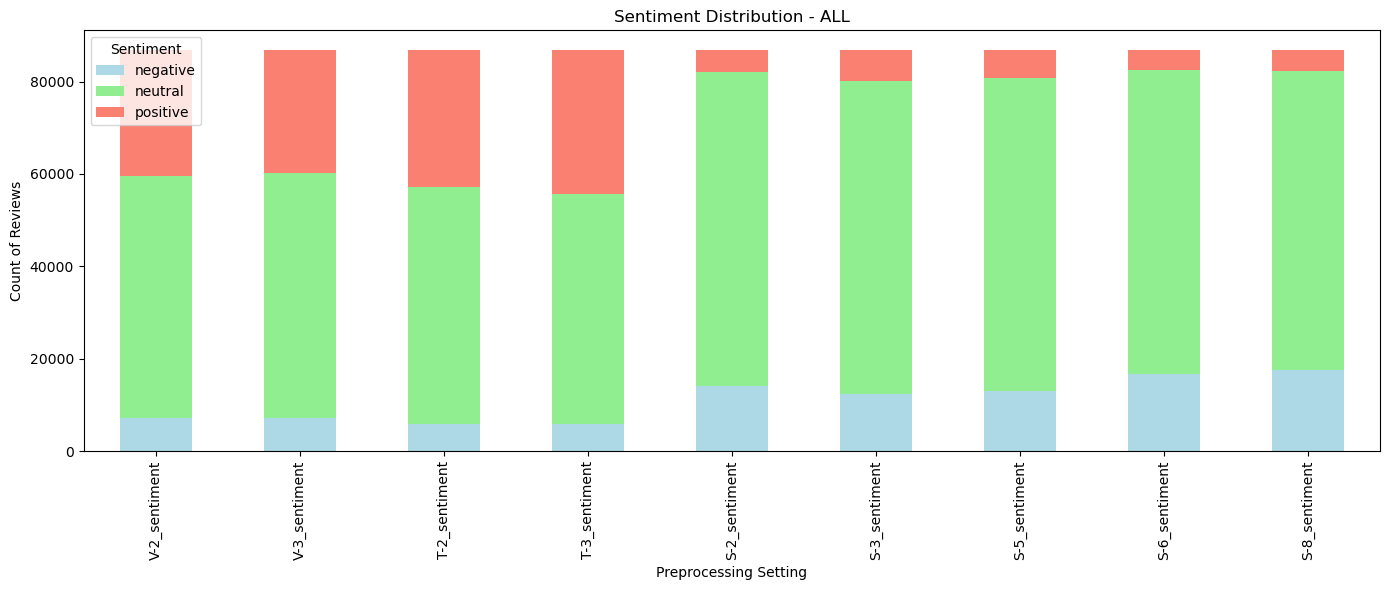

In [5]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
distribution = rule_based_result_df[[f'{col}_sentiment' for col in vader_columns +textblob_columns + stanza_columns ]].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - ALL')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


### rule-based Voting

In [6]:
# Map the sentiment labels to integers
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Apply classification to each sentiment analysis method
for col in vader_columns + textblob_columns + stanza_columns:
    rule_based_result_df[f'{col}_vote'] = rule_based_result_df[col + '_sentiment'].map(label_mapping)

vote_columns = [col for col in rule_based_result_df.columns if col.endswith('_vote')]
# Calculate the total votes for each review
rule_based_result_df['sum_score'] = rule_based_result_df[vote_columns].sum(axis=1)

In [7]:
# Calculate the maximum frequency and identify the corresponding sentiment
def determine_max_sentiment(pos_count, neg_count, neu_count):
    max_frequency = max(pos_count, neg_count, neu_count)
    
    if max_frequency == pos_count and pos_count > max(neg_count, neu_count):
        return 'positive', max_frequency
    elif max_frequency == neg_count and neg_count > max(pos_count, neu_count):
        return 'negative', max_frequency
    elif max_frequency == neu_count and neu_count > max(neg_count, pos_count):
        return 'neutral', max_frequency
    else:
        return 'tie', max_frequency

# Function to calculate the highest frequency of a value in a row
def calculate_highest_frequency(row):
    # Count the occurrences of each vote
    pos_count = sum(row[col] == 1 for col in vote_columns)
    neg_count = sum(row[col] == -1 for col in vote_columns)
    neu_count = sum(row[col] == 0 for col in vote_columns)
    
    max_sentiment, max_frequency = determine_max_sentiment(pos_count, neg_count, neu_count)
    return max_sentiment, max_frequency


rule_based_result_df[['rule_based_label', 'max_agreement_votes']] = rule_based_result_df.apply(
    lambda row: calculate_highest_frequency(row), axis=1, result_type='expand'
)

rule_based_result_df[vote_columns + ['rule_based_label', 'max_agreement_votes']].head()

,V-2_vote,V-3_vote,T-2_vote,T-3_vote,S-2_vote,S-3_vote,S-5_vote,S-6_vote,S-8_vote,rule_based_label,max_agreement_votes
0,0,0,0,0,0,0,0,0,0,neutral,9
1,0,0,0,0,0,0,0,0,0,neutral,9
2,0,0,0,0,0,0,0,0,0,neutral,9
3,-1,-1,-1,-1,0,0,0,0,0,neutral,5
4,0,0,0,0,0,0,0,0,0,neutral,9


In [8]:
# rule_based_result_df['rule_based_label'].value_counts() ,  rule_based_result_df['max_agreement_votes'].value_counts()

In [9]:
'''CONFIGURABLE'''
rule_based_result_df['others_agree_with_each_other'] = rule_based_result_df['max_agreement_votes']>= 6 
rule_based_result_df['others_agree_with_each_other'].value_counts()

others_agree_with_each_other
True     63267
False    23480
Name: count, dtype: int64

In [10]:
rule_based_result_df['vader_avg'] = rule_based_result_df[vader_columns].mean(axis=1)
rule_based_result_df['textblob_avg'] = rule_based_result_df[textblob_columns].mean(axis=1)
rule_based_result_df['stanza_avg'] = rule_based_result_df[stanza_columns].mean(axis=1)

rule_based_result_df['rule_based_score'] = rule_based_result_df[['vader_avg', 'textblob_avg', 'stanza_avg']].mean(axis=1)

columns_to_be_dropped = ['V-2', 'T-2', 'S-2', 'V-3','T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 
'V-8', 'T-8','S-8', 'V-9', 'T-9', 'S-9','V-2_sentiment', 'V-3_sentiment', 'T-2_sentiment', 'T-3_sentiment', 'S-2_sentiment',
'S-3_sentiment', 'S-5_sentiment', 'S-6_sentiment', 'S-8_sentiment','V-2_vote', 'V-3_vote', 'T-2_vote', 'T-3_vote', 'S-2_vote', 'S-3_vote',
'S-5_vote', 'S-6_vote', 'S-8_vote']
rule_based_result_df = rule_based_result_df.drop(columns = columns_to_be_dropped)

## gemini sentiment label

In [11]:
# gemini_result_df.GEMINI.value_counts()

In [12]:
'''CONFIGURABLE'''
def classify_sentiment_GEMINI(score):
    if -0.1 <= score <= 0.1:
        return 'neutral'
    elif score > 0.1:
        return 'positive'
    else:
        return 'negative'
gemini_result_df['GEMINI_label'] = gemini_result_df.GEMINI.apply(classify_sentiment_GEMINI)
gemini_result_df['GEMINI_label'].value_counts()

GEMINI_label
neutral     50328
positive    26698
negative     8721
Name: count, dtype: int64

## Merge GEMINI and RULE based

In [13]:
# Perform an inner merge on the specified columns
merged_df = pd.merge(
    rule_based_result_df,
    gemini_result_df,
    on=['file_name', 'x_min', 'x_max'],
    how='inner'
)
merged_df = merged_df.drop_duplicates(subset=['file_name', 'x_min', 'x_max'])
merged_df.shape

(85176, 25)

In [14]:
merged_df['others_agree_with_LLM'] = merged_df['rule_based_label']==merged_df['GEMINI_label']
merged_df['others_agree_with_LLM'].value_counts()

others_agree_with_LLM
True     50278
False    34898
Name: count, dtype: int64


if not 'other_agree_with_each_other' GEMINI 1  
else:   
    if agree with LLM:  GEMINI 0.7 others 0.3   
    else:   
        GEMINI 0.7 others 0.3 
calculate the final sentiment score  

In [15]:
# Function to calculate final sentiment score
def calculate_final_sentiment(row): 
    if not row['others_agree_with_each_other']:
        # If others don't agree with each other
        final_score = row['GEMINI'] * 1.0  # GEMINI 1, others 0
    else:
        # If others agree with each other
        if row['others_agree_with_LLM']:
            final_score = row['GEMINI'] * 0.7 + row['rule_based_score'] * 0.3  # GEMINI 0.7, others 0.3
        else:
            final_score = row['GEMINI'] * 0.8 + row['rule_based_score'] * 0.2  # GEMINI 0.8, others 0.2
    return final_score

# Apply the function to calculate the final sentiment score
merged_df['final_sentiment_score'] = merged_df.apply(calculate_final_sentiment, axis=1)

### hide distribution plot 

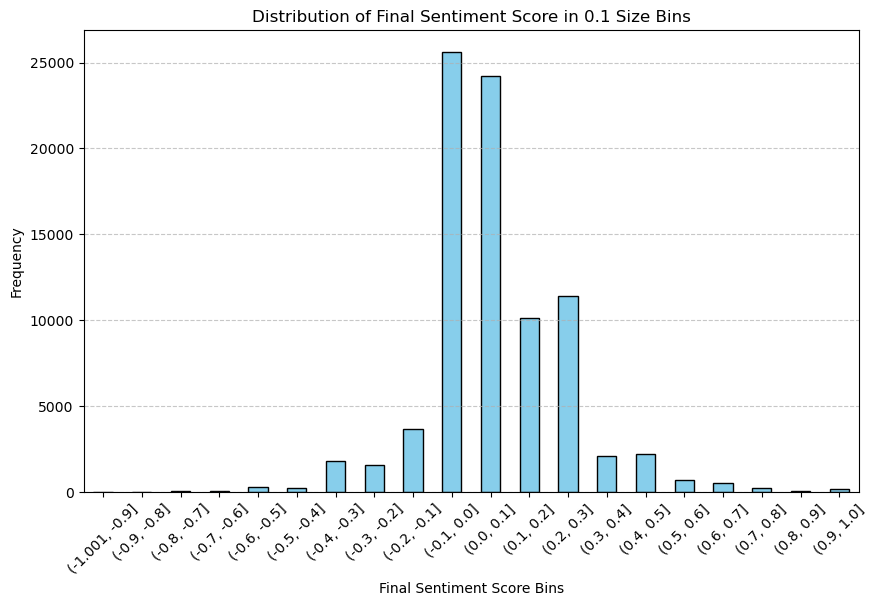

final_sentiment_score
(-1.001, -0.9]        5
(-0.9, -0.8]          1
(-0.8, -0.7]         63
(-0.7, -0.6]         49
(-0.6, -0.5]        321
(-0.5, -0.4]        236
(-0.4, -0.3]       1828
(-0.3, -0.2]       1596
(-0.2, -0.1]       3646
(-0.1, 0.0]       25608
(0.0, 0.1]        24214
(0.1, 0.2]        10129
(0.2, 0.3]        11411
(0.3, 0.4]         2092
(0.4, 0.5]         2246
(0.5, 0.6]          693
(0.6, 0.7]          544
(0.7, 0.8]          213
(0.8, 0.9]           76
(0.9, 1.0]          205
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(merged_df['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Final Sentiment Score in 0.1 Size Bins')
plt.xlabel('Final Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

## final label & filter

In [17]:
def classify_sentiment_final(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.1 <= score <= 0.1:
        return 'neutral'
    elif score > 0.1:
        return 'positive'
    else:
        return 'negative'
merged_df['final_sentiment_label'] = merged_df['final_sentiment_score'].apply(classify_sentiment_final)
merged_df['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     49827
positive    27609
negative     7740
Name: count, dtype: int64

In [18]:
merged_df_filtered = merged_df[(merged_df['duration']<8) & (merged_df['Speed']>1.8)]
merged_df_filtered['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     21991
positive    13380
negative     2679
Name: count, dtype: int64

### train test split

In [19]:
# merged_df_filtered[merged_df_filtered.session_id<=800].shape[0]/merged_df_filtered.shape[0],\
# merged_df_filtered[merged_df_filtered.session_id<=800]['final_sentiment_label'].value_counts()

In [20]:
# take first around 120 session id as test set 
testset_df = merged_df_filtered[merged_df_filtered.session_id<=800]
trainset_df = merged_df_filtered[merged_df_filtered.session_id>800]
trainset_df['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     17801
positive    10894
negative     2054
Name: count, dtype: int64

In [21]:
def sort_n_do_class_balancing(input_df, subset_size=1000):
    subsets = []
    for sentiment_class in ['positive', 'neutral', 'negative']:
        class_df = input_df[input_df['final_sentiment_label'] == sentiment_class]
        class_count = len(class_df)
        if class_count <= subset_size:
            subsets.append(class_df)
        else:
            if sentiment_class == 'neutral':
                class_df = class_df.loc[class_df['final_sentiment_score'].abs().sort_values().index]
            else:
                class_df = class_df.loc[class_df['final_sentiment_score'].abs().sort_values(ascending=False).index]
            subsets.append(class_df.head(subset_size))
    balanced_df = pd.concat(subsets).reset_index(drop=True)
    return balanced_df

# Example usage
train_balanced_df = sort_n_do_class_balancing(trainset_df, subset_size=2500)
print("training dataset balanced class distribution: ", train_balanced_df['final_sentiment_label'].value_counts())
test_balanced_df = sort_n_do_class_balancing(testset_df, subset_size=500)
print("testing dataset balanced class distribution: ", test_balanced_df['final_sentiment_label'].value_counts())

training dataset balanced class distribution:  final_sentiment_label
positive    2500
neutral     2500
negative    2054
Name: count, dtype: int64
testing dataset balanced class distribution:  final_sentiment_label
positive    500
neutral     500
negative    500
Name: count, dtype: int64


In [23]:
export_columns = ['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type','x_min', 'x_max', 
                  'cleaned_text_for_sentiment', 'word_count', 'duration', 'Speed','qualified_for_sentiment', 
                  'max_agreement_votes', 'others_agree_with_each_other', 'rule_based_score',  'GEMINI', 'explanation',
                  'GEMINI_label', 'others_agree_with_LLM', 'final_sentiment_score', 'final_sentiment_label']
train_balanced_df[export_columns].to_excel("../data/processed/IMDA_V3_Sentiment_label_0825_final_balanced_train_7054.xlsx", index=False)
test_balanced_df[export_columns].to_excel("../data/processed/IMDA_V3_Sentiment_label_0825_final_balanced_test_1500.xlsx", index=False)

In [25]:
rule_based_result_df.duration.describe()

count    86747.000000
mean         7.888948
std          3.210421
min          1.098380
25%          5.260630
50%          7.400490
75%         10.276710
max         14.999650
Name: duration, dtype: float64

# The END